# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-07-07 08:18:49.069508


In [3]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [4]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)
russian_data['cases_a_day'] = russian_data['cases'].diff().fillna(0)

russian_data['is_sick'] = russian_data['cases'] - (russian_data['recovered'] + russian_data['deaths'])
russian_data['lethality'] = russian_data['deaths'] / (russian_data['recovered'] + russian_data['deaths']) 

# Ситуация в Свердловской области

По данным [собранных какими-то энтузиастами данных](https://drive.google.com/drive/folders/1Y23J6QRt_yiyOI75KuZuIyVNeqS_sZpB?fbclid=IwAR31h9oNjZraz5etJKqRDjxYo7P6d40JpMe09D7ksXqPoDdg-c7nxU9n1yA).

In [5]:
from io import BytesIO
import requests

from scipy.stats import spearmanr

In [6]:
key = '1ExhvnWuc6-1Y8VkOLg0YAbhBUG6k8rRz'
google_sheet = f'https://docs.google.com/spreadsheets/d/{key}/export#gid=0&format=csv'
raw_data = requests.get(google_sheet).content

In [7]:
def select_region(df, region, start_date=None):
    region_df = df[['date', 'status', region]]
    region_df['date'] = region_df['date'].fillna(method='ffill')
    region_df = region_df.set_index(['date', 'status']).unstack()
    region_df.columns = region_df.columns.droplevel(0)
    region_df = region_df.rename(columns={'died': 'all_death',
                              'infected': 'all_cases',
                              'recovered': 'all_healthy'})
    region_df = region_df.reset_index()
    region_df['date'] = pd.to_datetime(region_df['date'])
    region_df = region_df.sort_values('date')
    if start_date is not None:
        region_df = region_df[region_df['date']>=start_date].reset_index().drop(columns=['index'])
    holidays = list(region_df[region_df['date'].dt.weekday.isin([5,6])]['date'].values)
    for date in pd.to_datetime(['01-05-2020', '04-05-2020', '05-05-2020', '11-05-2020', '12-06-2020'],
                              dayfirst=True):
        holidays.append(date)
    region_df['is_workday'] = region_df['date'].apply(lambda x: 0 if x in holidays else 1)
    region_df = region_df.reset_index().rename(columns={'index': 'day_number_from_start'}).set_index('date')
    region_df['day_number_from_start'] = region_df['day_number_from_start'].values + 1
    region_df['new_death'] = region_df['all_death'].diff(-1)
    region_df['new_cases'] = region_df['all_cases'].diff().fillna(0)
    region_df['is_sick'] = region_df['all_cases'] - (region_df['all_healthy'] + region_df['all_death'])
    return region_df

In [8]:
df = pd.read_excel(BytesIO(raw_data)).rename(columns={'Unnamed: 0': 'date', 'Unnamed: 1': 'status'})

In [9]:
df.columns

Index(['date', 'status', 'Москва', 'Московская область', 'Санкт-Петербург',
       'Нижегородская область', 'Свердловская область', 'Ханты-Мансийский АО',
       'Ростовская область', 'Красноярский край', 'Иркутская область',
       'Воронежская область', 'Республика Дагестан', 'Челябинская область',
       'Тульская область', 'Саратовская область', 'Волгоградская область',
       'Ямало-Ненецкий автономный округ', 'Новосибирская область',
       'Брянская область', 'Ульяновская область', 'Краснодарский край',
       'Калужская область', 'Архангельская область', 'Мурманская область',
       'Ставропольский край', 'Республика Башкортостан', 'Республика Чувашия',
       'Рязанская область', 'Пензенская область', 'Самарская область',
       'Курская область', 'Кабардино-Балкарская Республика',
       'Ивановская область', 'Республика Тыва', 'Ярославская область',
       'Тамбовская область', 'Белгородская область', 'Смоленская область',
       'Республика Татарстан', 'Орловская область', 

In [10]:
ekb = select_region(df, 'Свердловская область', start_date=pd.to_datetime('18-04-2020', dayfirst=True))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


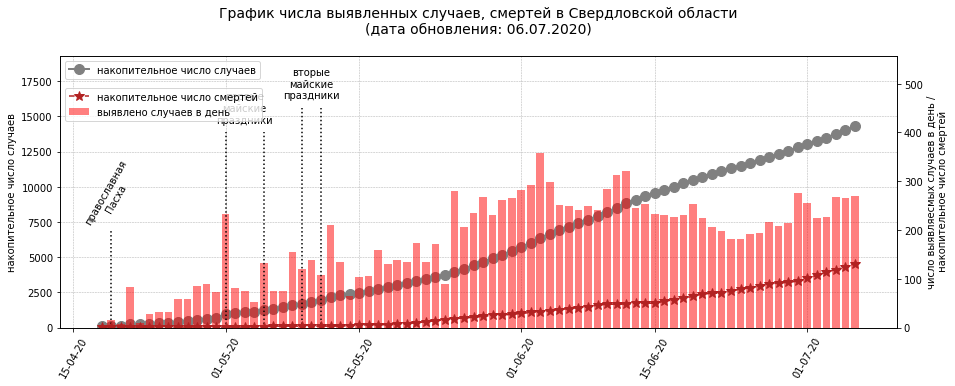

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(ekb['all_cases'], color='grey', marker='o', 
         linewidth=2, markersize=10, label='накопительное число случаев')

ax1.set_ylim(0, ekb['all_cases'].max()+5000)

# ===== вторая ось ========
ax2 = ax1.twinx()

ax2.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         200,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax2.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           200, 
           linestyle=':')


ax2.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           400, 
           linestyle=':')
ax2.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         420,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax2.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           400, 
           linestyle=':')

ax2.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           450, 
           linestyle=':')
ax2.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         470,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', 
         rotation=0)
ax2.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           450, 
           linestyle=':')

ax2.plot(ekb.query('all_death > 0')['all_death'], color='firebrick', marker='*', linestyle='--', 
         markersize=10, label='накопительное число смертей')

ax2.bar(x=ekb.index, 
        height=ekb['new_cases'], 
        color='red', alpha=0.5, label='выявлено случаев в день')

ax2.set_ylim(0, ekb['new_cases'].max()+200)

title = '''График числа выявленных случаев, смертей в Свердловской области
(дата обновления: {:%d.%m.%Y})
'''.format(ekb.index.max())

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

plt.title(title, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

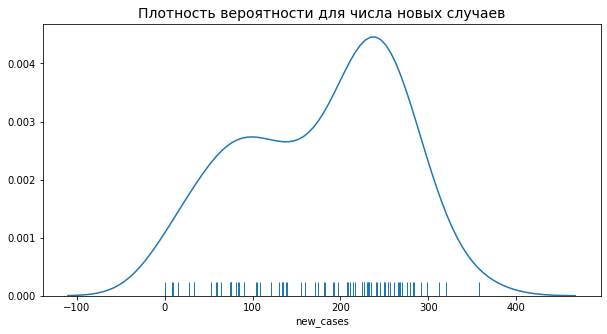

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(ekb['new_cases'],
             rug=True, hist=False)
plt.title('Плотность вероятности для числа новых случаев', fontsize=14)
plt.show()

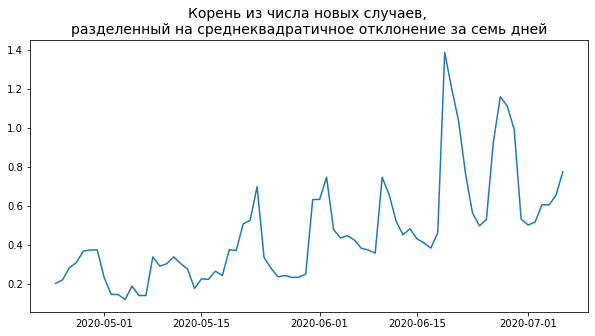

In [13]:
plt.figure(figsize=(10,5))
plt.plot(ekb['new_cases'].apply(lambda x: np.sqrt(x)) / ekb['new_cases'].rolling(7).std())
plt.title('Корень из числа новых случаев, \nразделенный на среднеквадратичное отклонение за семь дней', fontsize=14)
plt.show()

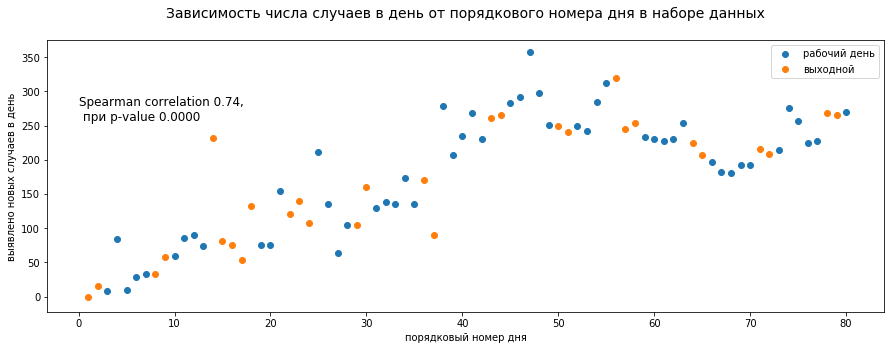

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=ekb.query('is_workday == 1')['day_number_from_start'],
            y=ekb.query('is_workday == 1')['new_cases'], label='рабочий день')
plt.scatter(x=ekb.query('is_workday == 0')['day_number_from_start'],
            y=ekb.query('is_workday == 0')['new_cases'], label='выходной')


sprm = spearmanr(ekb['day_number_from_start'].values, 
                 ekb['new_cases'].values,
                 nan_policy='omit')
plt.text(0, ekb['new_cases'].max()-100, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)

plt.xlabel('порядковый номер дня')
plt.ylabel('выявлено новых случаев в день')
plt.title('Зависимость числа случаев в день от порядкового номера дня в наборе данных\n', fontsize=14)

plt.legend()
plt.show()

**Летальность** рассчитывается от числа разрешившихся случаев. Считать ее от «общего числа случаев» неверно с точки зрения сравнения данных (так как не известно, как разрешатся случаи, которые еще «в процессе»).

In [15]:
ekb['lethality'] = ekb['all_death'] / (ekb['all_healthy'] + ekb['all_death']) 
ekb['lethality'].describe()

count    80.000000
mean      0.012144
std       0.002544
min       0.006369
25%       0.011129
50%       0.012265
75%       0.012904
max       0.020000
Name: lethality, dtype: float64

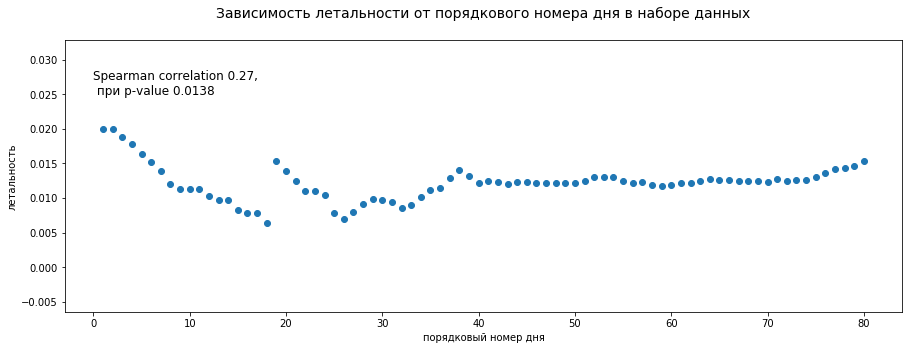

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=ekb['day_number_from_start'],
            y=ekb['lethality'])
sprm = spearmanr(ekb['day_number_from_start'].values, 
                 ekb['lethality'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('летальность')
plt.title('Зависимость летальности от порядкового номера дня в наборе данных\n', fontsize=14)

plt.text(0, ekb['lethality'].max()+0.005, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.show()

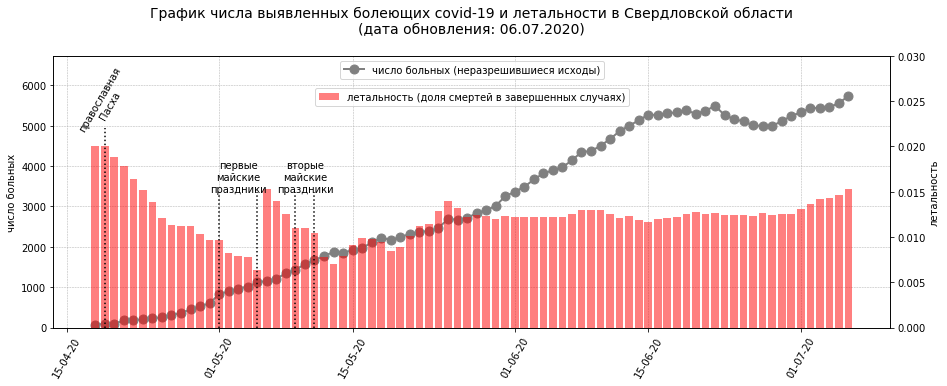

In [17]:
   
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(ekb['is_sick'], color='grey', marker='o', 
         linewidth=2, markersize=9, label='число больных (неразрешившиеся исходы)')

ax1.set_ylim(0, ekb['is_sick'].max()+1000)

# ===== вторая ось ========
ax2 = ax1.twinx()

ax2.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         0.021,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax2.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           0.022, 
           linestyle=':')


ax2.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           0.015, 
           linestyle=':')
ax2.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         0.015,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax2.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           0.015, 
           linestyle=':')

ax2.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           0.015, 
           linestyle=':')
ax2.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         0.015,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', 
         rotation=0)
ax2.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           0.015, 
           linestyle=':')


ax2.bar(x=ekb.index, 
        height=ekb['lethality'], 
        color='red', alpha=0.5, label='летальность (доля смертей в завершенных случаях)')

ax2.set_ylim(0, ekb['lethality'].max()+0.01)

title = '''График числа выявленных болеющих covid-19 и летальности в Свердловской области
(дата обновления: {:%d.%m.%Y})
'''.format(ekb.index.max())

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(loc='upper center')
ax2.legend(loc='upper center', bbox_to_anchor=(0.25, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('число больных')
ax2.set_ylabel('летальность')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

# Сравнение со всей Россией

In [18]:
msk = select_region(df, 'Москва')
mo = select_region(df, 'Московская область')
spb = select_region(df, 'Санкт-Петербург')
nn = select_region(df, 'Нижегородская область')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


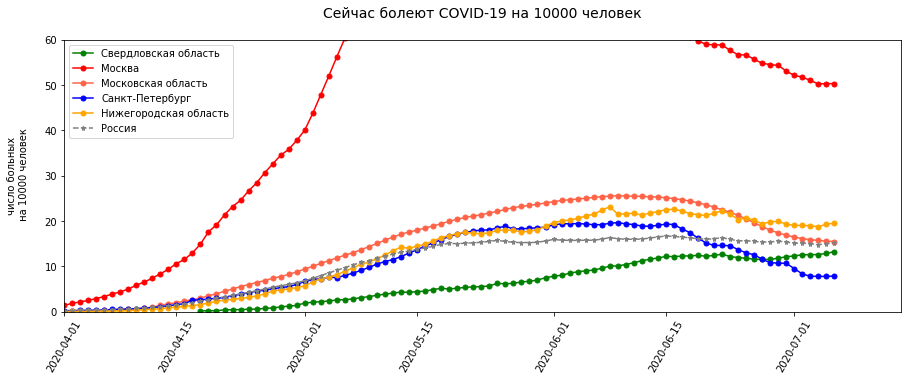

In [19]:
n = 10000
start_date = pd.to_datetime('01-04-2020', dayfirst=True)

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(ekb['is_sick'] / 4325256 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Свердловская область')

plt.plot(msk['is_sick'] / 12692466 * n, color='red', 
         marker='o', linestyle='-', markersize=5, label='Москва')

plt.plot(mo['is_sick'] / 12692466 * n, color='tomato', 
         marker='o', linestyle='-', markersize=5, label='Московская область')

plt.plot(spb['is_sick'] / 5398064 * n, color='blue', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(nn['is_sick'] / 3202946 * n, color='orange', 
         marker='o', linestyle='-', markersize=5, label='Нижегородская область')

plt.plot(russian_data['is_sick'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Сейчас болеют COVID-19 на {n} человек\n', fontsize=14)
plt.legend()
plt.ylim(0, 60)
plt.xlim(start_date)
plt.ylabel(f'число больных\n на {n} человек\n')
plt.show()

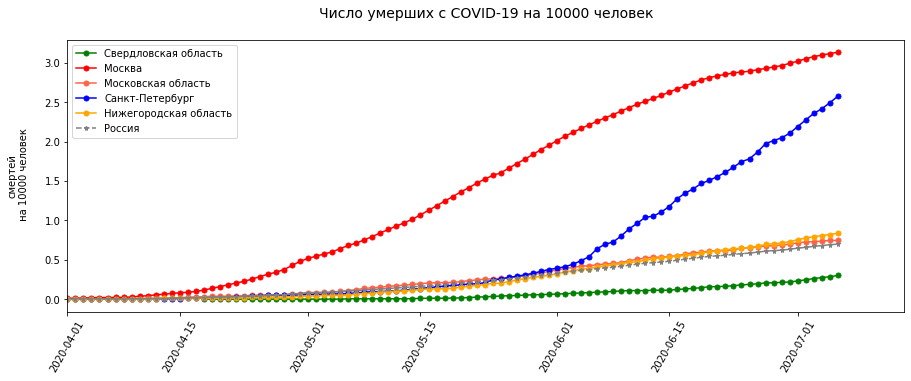

In [20]:
n = 10000
start_date = pd.to_datetime('01-04-2020', dayfirst=True)

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(ekb['all_death'] / 4325256 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Свердловская область')

plt.plot(msk['all_death'] / 12692466 * n, color='red', 
         marker='o', linestyle='-', markersize=5, label='Москва')

plt.plot(mo['all_death'] / 12692466 * n, color='tomato', 
         marker='o', linestyle='-', markersize=5, label='Московская область')

plt.plot(spb['all_death'] / 5398064 * n, color='blue', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(nn['all_death'] / 3202946 * n, color='orange', 
         marker='o', linestyle='-', markersize=5, label='Нижегородская область')

plt.plot(russian_data['deaths'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Число умерших с COVID-19 на {n} человек\n', fontsize=14)
plt.legend()
#plt.ylim(0, 60)
plt.xlim(start_date)
plt.ylabel(f'смертей\n на {n} человек\n')
plt.show()